In [7]:
import matplotlib.pyplot as plt

from pathlib import Path
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.wcs as fitswcs
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, get_moon, Angle
from astropy.time import Time
from astropy.table import Table
import astroplan
from specutils.spectra.spectrum1d import Spectrum1D
from astropy.visualization import quantity_support
from specutils.io.registers import custom_writer
from specutils.manipulation import FluxConservingResampler

_ = quantity_support()
%matplotlib widget

In [4]:
@custom_writer("fits-writer")
def generic_fits(spectrum, file_name, overwrite=False, **kwargs):
    flux = spectrum.flux.value
    disp = spectrum.spectral_axis.value
    meta = spectrum.meta

    tab = Table([disp, flux], names=("spectral_axis", "flux"), meta=meta)

    tab.write(file_name, format="fits", overwrite=overwrite)

In [5]:
MMT_LOCATION = EarthLocation.from_geodetic("-110:53:04.4", "31:41:19.6", 2600 * u.m)
MMT = astroplan.Observer(name="MMTO", location=MMT_LOCATION, timezone="US/Arizona", pressure=0*u.mbar)

In [6]:
def load_spectrum(fitsfile):
    hdul = fits.open(fitsfile)
    hdu = hdul[0]
    hdu.verify('fix')
    h = hdul[0].header
    s_hdr = {
        'CDELT1': h['CDELT1'],
        'CRVAL1': h['CRVAL1'],
        'CUNIT1': 'Angstrom',
        'CTYPE1': h['CTYPE1'],
        'CRPIX1': h['CRPIX1']
    }
    counts = hdul[0].data[2][0] / h['EXPTIME']
    s_wcs = fitswcs.WCS(header=s_hdr)
    sp = Spectrum1D(flux=counts * u.count/u.second, wcs=s_wcs)
    return sp

 [astropy.io.fits.verify]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
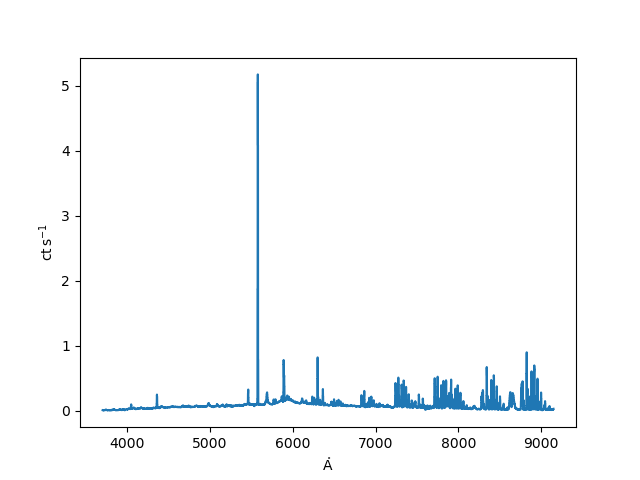

In [9]:
s = load_spectrum("data/2012.0316/skysub_m87.2012a_3/skydir/001.sky.ms.fits")
#s = Spectrum1D.read("2012.0316/skysub_m87.2012a_3/skydir/001.sky.ms.fits", format='wcs1d-fits')
plt.step(s.spectral_axis, s.flux)
plt.show()
s.write("blah.fits", format="fits-writer", overwrite=True)

In [10]:
drop = ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND', 'CTYPE1', 'CRVAL1', 'CRPIX1', 'CDELT1', 'CDELT2']
def combine_skies(obsdir):
    """
    Combine data from multiple sky fibers into one sky spectrum
    """
    p = Path(obsdir) / "skydir"
    skies = list(p.glob("*.ms.fits"))
    n = len(skies)
    init_sky = skies.pop(0)
    init_spec = load_spectrum(init_sky)
    hdu = fits.open(skies[0])[0]
    hdu.verify('fix')
    hdr = hdu.header
    utc = Time(hdr['DATE-OBS'])
    coords = SkyCoord(f"{hdr['RA']} {hdr['DEC']}", unit=(u.hourangle, u.deg))
    aa_frame = AltAz(obstime=utc, location=MMT_LOCATION)
    alt_az = coords.transform_to(aa_frame)
    hdr['ALT'] = alt_az.alt.to_string()
    hdr['AZ'] = alt_az.az.to_string()
    moon = get_moon(utc, MMT_LOCATION)
    moon_aa = moon.transform_to(aa_frame)
    hdr['MOON_ALT'] = moon_aa.alt.to_string()
    hdr['MOON_AZ'] = moon_aa.az.to_string()
    illum = 100 * astroplan.moon_illumination(utc)
    hdr['MOON_ILL'] = f"{illum:.0f}"
    for k in drop:
        del hdr[k]
    for sp in skies:
        init_spec += load_spectrum(sp)
    comb_sp = Spectrum1D(spectral_axis=init_spec.spectral_axis, flux=init_spec.flux/n, wcs=init_spec.wcs)
    comb_sp.meta['header'] = hdr
    return comb_sp

In [12]:
csp = combine_skies("data/2020.1025/skysub_m31_pne_20_8")
csp.write("blah.fits",  overwrite=True)

In [13]:
len(list(Path("./data").glob("20*")))

833

In [14]:
datadirs = Path("./data").glob("20*")
for d in datadirs:
    obsdirs = d.glob("*")
    for o in obsdirs:
        if o.is_dir():
            outfile = f"{str(o)}_comb.fits"
            if Path(outfile).exists():
                print(f"Skipping {outfile}...")
            else:
                print(f"Processing {outfile}...")
                sp = combine_skies(o)
                sp.write(outfile, overwrite=True)

Skipping data/2013.0510/skysub_NSA147100_4_comb.fits...
Skipping data/2013.0510/skysub_hectomap_2013b2_14_comb.fits...
Skipping data/2013.0510/skysub_NSA147100_6_comb.fits...
Skipping data/2013.0510/skysub_NSA147100_5_comb.fits...
Skipping data/2008.0414/skysub_a2220a_1_comb.fits...
Skipping data/2008.0414/skysub_a1361a_1_comb.fits...
Skipping data/2008.0414/skysub_cl1206m0744a_1_comb.fits...
Skipping data/2008.0414/skysub_a2055c_1_comb.fits...
Skipping data/2008.0414/skysub_ngc1960_6_comb.fits...
Skipping data/2008.0414/skysub_a1930a_1_comb.fits...
Skipping data/2008.0414/skysub_mmtlist.nospec_1_comb.fits...
Skipping data/2008.0414/skysub_a1978b_1_comb.fits...
Skipping data/2008.0414/skysub_a1437c_1_comb.fits...
Skipping data/2008.0414/skysub_ngc1960_8_comb.fits...
Skipping data/2011.0708/skysub_UAO-S21_hecto_21_comb.fits...
Skipping data/2011.0708/skysub_SDSS_J172058.67+352018.6_1hour_2011B_2_comb.fits...
Skipping data/2010.0511/skysub_cosmos_rm_10_1_comb.fits...
Skipping data/2010.0

Processing data/2021.1003/skysub_MMT_2021_FIELD1_1_comb.fits...


Processing data/2021.1003/skysub_NGC57_wide_clean_1_comb.fits...


Processing data/2021.1003/skysub_jiang_p1_1_comb.fits...


Processing data/2021.1003/skysub_NGC57_wide_clean_2_comb.fits...


Processing data/2021.1003/skysub_NEPc21_4_comb.fits...


Skipping data/2019.1025/skysub_Rank16_1_comb.fits...
Skipping data/2019.1025/skysub_vicyg9_1_comb.fits...
Skipping data/2019.1025/skysub_Rank06_1_comb.fits...
Skipping data/2019.1025/skysub_cluster10_2_comb.fits...
Skipping data/2019.1025/skysub_m31_pne_19_5_comb.fits...
Skipping data/2019.1025/skysub_Rank28_1_comb.fits...
Skipping data/2019.1025/skysub_cl357_1_comb.fits...
Skipping data/2019.1025/skysub_Rank13_1_comb.fits...
Skipping data/2014.1117/skysub_SDSS_J010433.20+125114.3_1hour_2014C_2_comb.fits...
Skipping data/2014.1117/skysub_M31symb_nov14_2_comb.fits...
Skipping data/2014.1117/skysub_m33wr_1_comb.fits...
Skipping data/2014.1117/skysub_M33symb_nov14_2_comb.fits...
Skipping data/2014.1117/skysub_a0657a_1_comb.fits...
Skipping data/2014.1117/skysub_rmj075100p173753a_2_comb.fits...
Skipping data/2014.1117/skysub_a0657a_2_comb.fits...
Skipping data/2014.1117/skysub_J1122+5755_1_comb.fits...
Skipping data/2014.1117/skysub_rmj075100p173753a_1_comb.fits...
Skipping data/2018.0318/

Processing data/2021.1112/skysub_2021_CAT_1_comb.fits...


Processing data/2021.1112/skysub_NEPc21_5_comb.fits...


Skipping data/2017.0425/skysub_ELAIS_N1_8_comb.fits...
Skipping data/2009.0220/skysub_booiii_2009a_1-HD154345_1_comb.fits...
Skipping data/2009.0220/skysub_booiii_2009a_1_comb.fits...
Skipping data/2009.0220/skysub_finkelstein_600_1_comb.fits...
Skipping data/2009.0220/skysub_l1641col2d_5_comb.fits...
Skipping data/2009.0220/skysub_lh4_20_comb.fits...
Skipping data/2009.0220/skysub_l1641col2d_6_comb.fits...
Skipping data/2019.0427/skysub_A2065a19_5_comb.fits...
Skipping data/2019.0427/skysub_A2065a19_2_comb.fits...
Skipping data/2019.0427/skysub_jiang_1_comb.fits...
Skipping data/2011.0926/skysub_sko_b1_1_comb.fits...
Skipping data/2011.0926/skysub_W1_A_2011C_2_comb.fits...
Skipping data/2011.0926/skysub_m31em_1_comb.fits...
Skipping data/2011.0926/skysub_m31wrs_3_comb.fits...
Skipping data/2011.0926/skysub_mmt_1_1_comb.fits...
Skipping data/2017.0427/skysub_a2261_2_comb.fits...
Skipping data/2017.0427/skysub_Bezanson_uvista_2_comb.fits...
Skipping data/2017.0427/skysub_ELAIS_N1_8_comb

Processing data/2021.0709/skysub_mmt_nsa165980_1_comb.fits...


Processing data/2021.0709/skysub_A2244b21_1_comb.fits...
Processing data/2021.0709/skysub_A7b21_1_comb.fits...


Processing data/2021.0709/skysub_NEPb21_1_comb.fits...
Skipping data/2015.0417/skysub_hectomap_2015a1_9_comb.fits...
Skipping data/2015.0417/skysub_hectomap_2015a1_11_comb.fits...
Skipping data/2015.0417/skysub_hectomap_2015a1_8_comb.fits...
Skipping data/2015.0417/skysub_G244_input_1_comb.fits...
Skipping data/2015.0417/skysub_cosmos15a2_4_comb.fits...
Skipping data/2015.0417/skysub_Feige-34_pm2_1_comb.fits...
Skipping data/2015.0417/skysub_J1029_xfitfibsinput_high_rearranged_1_comb.fits...
Skipping data/2012.0222/skysub_PG1522_2_comb.fits...
Skipping data/2012.0222/skysub_m81blue_1_comb.fits...
Skipping data/2012.0222/skysub_PG1206_3_comb.fits...
Skipping data/2012.0222/skysub_m87.2012a_1_comb.fits...
Skipping data/2012.0222/skysub_A2146_long4_1_comb.fits...
Skipping data/2012.0222/skysub_Feige-34_pm2_1_comb.fits...
Skipping data/2012.0222/skysub_m81blue_1_7300_comb.fits...
Skipping data/2007.0719/skysub_m31gc_sum07_2_comb.fits...
Skipping data/2009.0722/skysub_A68_LoCuSS_1_comb.fits

WARNING

Processing data/2021.1002/skysub_NEPc21_1_comb.fits...


: Meta-data keyword GCOUNT will be ignored since it conflicts with a FITS reserved keyword [astropy.io.fits.convenience]


Skipping data/2010.0624/skysub_HectoMap_gray.3-may-2010_60_comb.fits...
Skipping data/2010.0624/skysub_cygxspr10_19_23a_2_comb.fits...
Skipping data/2010.0624/skysub_HectoMap_gray.3-may-2010_9_comb.fits...
Skipping data/2010.0624/skysub_HectoMap_gray.3-may-2010_63_comb.fits...
Skipping data/2010.0624/skysub_HectoMap_gray.3-may-2010_29_comb.fits...
Skipping data/2012.0519/skysub_HectoMap.24-apr-2012_3_comb.fits...
Skipping data/2012.0519/skysub_Feige-66_pm2_1_comb.fits...
Skipping data/2012.0519/skysub_cygnus2_i16_2_comb.fits...
Skipping data/2012.0519/skysub_HectoMap.24-apr-2012_4_comb.fits...
Skipping data/2012.0519/skysub_HectoMap.24-apr-2012_6_comb.fits...
Skipping data/2012.0519/skysub_cygnus2_i20_3_comb.fits...
Skipping data/2012.0519/skysub_m60.2012b.s2_1_comb.fits...
Skipping data/2009.1215/skysub_W3_18-20_2009c_v3_Final_2_comb.fits...
Skipping data/2009.1215/skysub_hectospec_candidates_list2_3_comb.fits...
Skipping data/2009.1215/skysub_m33fntOI_4_comb.fits...
Skipping data/200

Skipping data/2009.1126/skysub_A689_LoCuSS_2_comb.fits...
Skipping data/2009.1126/skysub_W3_18-20_2009c_v3_Final_1_comb.fits...
Skipping data/2009.1126/skysub_A689_LoCuSS_3_comb.fits...
Skipping data/2009.1126/skysub_hectospec_candidates_list2_3_comb.fits...
Skipping data/2009.1126/skysub_m31fntOI_2_comb.fits...
Skipping data/2009.1126/skysub_m31brtOI_2_comb.fits...
Skipping data/2009.1126/skysub_hectospec_candidates_list2_4_comb.fits...
Skipping data/2009.1126/skysub_m31brtOI_3_comb.fits...
Skipping data/2009.1126/skysub_m31fntOI_3_comb.fits...
Skipping data/2019.0507/skysub_hectomap_2019b1_12_comb.fits...
Skipping data/2019.0507/skysub_hectomap_2019b1_10_comb.fits...
Skipping data/2019.0507/skysub_A2255b19_2_comb.fits...
Skipping data/2019.0507/skysub_A2255b19_1_comb.fits...
Skipping data/2019.0507/skysub_mmt_nsa143856_1_comb.fits...
Skipping data/2016.0502/skysub_hectomap_2016b1_1_comb.fits...
Skipping data/2016.0502/skysub_Bezanson_uvista_4_comb.fits...
Skipping data/2016.0502/skys

Processing data/2021.1113/skysub_2021_CAT_4_comb.fits...


Processing data/2021.1113/skysub_2021_CAT_1_comb.fits...


Processing data/2021.1113/skysub_2021_CAT_3_comb.fits...


Processing data/2021.1113/skysub_mmt_nsa47117_1_comb.fits...


Skipping data/2011.0923/skysub_IC1805_le16v_31aug2011_1_short_comb.fits...
Skipping data/2011.0923/skysub_m31wrs_2_comb.fits...
Skipping data/2011.0923/skysub_md10-i310020_1_comb.fits...
Skipping data/2011.0923/skysub_m31wrs_1_comb.fits...
Skipping data/2011.0923/skysub_mmt_2_1_comb.fits...
Skipping data/2011.0923/skysub_IC1805_le16v_31aug2011_1_long_comb.fits...
Skipping data/2017.1002/skysub_DEEP23_1_comb.fits...
Skipping data/2017.1002/skysub_m31wr17_4_comb.fits...
Skipping data/2017.1002/skysub_BD+28-4211_pm2_1_comb.fits...
Skipping data/2017.1002/skysub_HD-217086_pm2_1_comb.fits...
Skipping data/2020.0624/skysub_A2069b20_5_comb.fits...
Skipping data/2020.0624/skysub_mmt_nsa150578_v2_1_comb.fits...
Skipping data/2020.0624/skysub_A2069b20_4_comb.fits...
Skipping data/2020.0624/skysub_A2034b20_1_comb.fits...
Skipping data/2013.1005/skysub_a0344a_2_comb.fits...
Skipping data/2013.1005/skysub_a0344a_1_comb.fits...
Skipping data/2013.1005/skysub_m33bin13_1_comb.fits...
Skipping data/201

Processing data/2021.1111/skysub_MMT_2021_FIELD1_1_comb.fits...
Processing data/2021.1111/skysub_2021_CAT_2_comb.fits...


Processing data/2021.1111/skysub_NGC57_centblue_X_1_comb.fits...
Skipping data/2012.1203/skysub_east.2012_17_comb.fits...
Skipping data/2012.1203/skysub_east.2012_18_comb.fits...
Skipping data/2012.1203/skysub_hwang_sao10_2012oct5_6_comb.fits...
Skipping data/2016.1008/skysub_M31c16_1_comb.fits...
Skipping data/2016.1008/skysub_A2390c16_4_comb.fits...
Skipping data/2004.1106/skysub_sori_hecto_new_1_comb.fits...
Skipping data/2016.1004/skysub_m312016_1_comb.fits...
Skipping data/2016.1004/skysub_A2390c16_2_comb.fits...
Skipping data/2016.1004/skysub_catalog_hectospec_1_comb.fits...
Skipping data/2016.1004/skysub_PS1_host_2016C_md10_4_comb.fits...
Skipping data/2016.1004/skysub_MMT-Targets_Selected_MMT_Sept2016_1_comb.fits...
Skipping data/2016.1004/skysub_catalog_hectospec_2_comb.fits...
Skipping data/2016.1004/skysub_M33symb_sep2016_1_comb.fits...
Skipping data/2012.0518/skysub_ADeyUAOS6BwDrop_1_comb.fits...
Skipping data/2012.0518/skysub_combined_list_MD05_x_4_comb.fits...
Skipping da

In [15]:
with open("sky_spectra.csv", 'w') as outf:
    outf.write("file,ut,alt,az,moon_alt,moon_az,moon_ill,disperser\n")
    with open("comblist", 'r') as fp:
        for f in fp.readlines():
            f = f.strip()
            sp = Spectrum1D.read(f)
            outstr = (
                f"{f},"
                f"{sp.meta['header']['DATE-OBS']},"
                f"{Angle(sp.meta['header']['ALT']).value:.2f},"
                f"{Angle(sp.meta['header']['AZ']).value:.2f},"
                f"{Angle(sp.meta['header']['MOON_ALT']).value:.2f},"
                f"{Angle(sp.meta['header']['MOON_AZ']).value:.2f},"
                f"{sp.meta['header']['MOON_ILL']},"
                f"{sp.meta['header']['DISPERSE']}"
                "\n"
            )
            outf.write(outstr)

In [16]:
df = pd.read_csv("sky_spectra.csv")
moonfree = df[(df['moon_alt'] < -6)]
moonfree

,file,ut,alt,az,moon_alt,moon_az,moon_ill,disperser
0,./data/2013.0510/skysub_hectomap_2013b2_14_com...,2013-05-10T04:53:05,65.41,54.06,-28.85,317.34,0,270_gpm
1,./data/2013.0510/skysub_NSA147100_5_comb.fits,2013-05-10T09:34:55,72.83,227.06,-33.55,33.57,0,270_gpm
2,./data/2013.0510/skysub_NSA147100_4_comb.fits,2013-05-10T08:04:00,74.86,142.04,-40.48,9.04,0,270_gpm
3,./data/2013.0510/skysub_NSA147100_6_comb.fits,2013-05-10T11:08:15,55.25,259.46,-20.38,52.42,0,270_gpm
6,./data/2008.0414/skysub_a2220a_1_comb.fits,2008-04-14T11:37:21,64.52,336.42,-21.03,306.06,68,270_gpm
...,...,...,...,...,...,...,...,...
4159,./data/2010.1011/skysub_m33wr_2_comb.fits,2010-10-11T04:51:14,54.16,81.15,-21.36,254.28,15,270_gpm
4160,./data/2010.1011/skysub_W3_brmed18_v3_2010C_3_...,2010-10-11T12:09:29,43.83,328.06,-66.50,77.62,18,270_gpm
4161,./data/2010.1011/skysub_md1-i80516_1_comb.fits,2010-10-11T06:44:26,44.86,141.13,-43.98,266.16,16,270_gpm
4162,./data/2010.1011/skysub_xmm_lss_2010_rev_2_com...,2010-10-11T08:36:55,53.12,183.40,-66.59,283.00,17,270_gpm


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
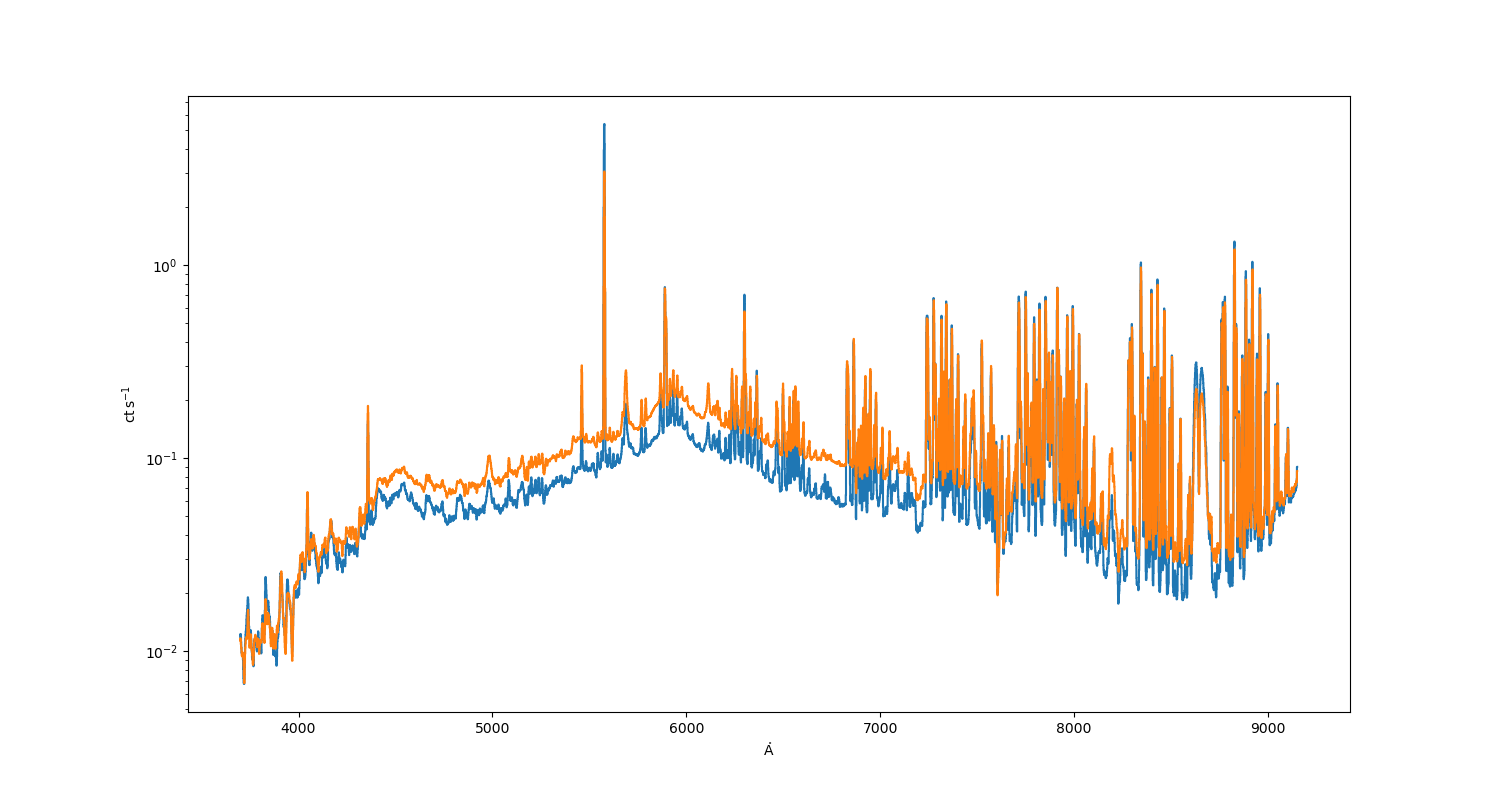

In [17]:
test = Spectrum1D.read("./data/2020.1013/skysub_m31_pne_20_9_comb.fits")
t2 = Spectrum1D.read("./data/2020.1024/skysub_jiang_c2_1_comb.fits")
plt.figure(figsize=[15,8])
plt.step(test.spectral_axis, test.flux)
plt.step(t2.spectral_axis, t2.flux)
plt.yscale('log')
plt.show()

In [18]:
t2.meta['header'].keys()

odict_keys(['ORIGIN', 'DATE', 'IRAF-TLM', 'OBJECT', 'SERIALID', 'FILENAME', 'NAMPS', 'AMPNAME', 'GAIN', 'RDNOISE', 'SECPIX1', 'SECPIX2', 'VRGLO', 'VRGHI', 'VSLO', 'VSHI', 'VPLO', 'VPHI', 'VOG1', 'VOG2', 'VRD', 'VDD', 'VODR', 'VTEMP', 'DEWTEMP', 'CCDSIGNM', 'CCDFASTC', 'CCDSLOWC', 'CCDLTIME', 'CCDGAIN', 'CAMGAIN', 'BPM', 'CCDTEMP', 'CCDOVERR', 'CCDLOSTB', 'CCDTMOUT', 'OBSERVAT', 'OBSERVER', 'PROPID', 'PI', 'DARKTIME', 'IMAGETYP', 'OBSMODE', 'APTYPE', 'EXPTIME', 'DATE-OBS', 'UT', 'ST', 'MJD', 'RA', 'DEC', 'EQUINOX', 'GDRELOFF', 'AIRMASS', 'ROTANGLE', 'PRESSURE', 'TELFOCUS', 'SEEING', 'TELESCOP', 'DETECTOR', 'ALTTIMIN', 'NSCANROW', 'INSTRUME', 'APERTURE', 'DISPERSE', 'TILTPOS', 'INSFOCUS', 'MMTCAMPW', 'CIFOCUS', 'CTILTPOS', 'POSANGLE', 'HA', 'INSTAZ', 'INSTEL', 'PARANGLE', 'CAT-ID', 'CAT-RA', 'CAT-DEC', 'CORRCTOR', 'ADC', 'ADCPRSME', 'ADCPRSMW', 'ADCTRACK', 'ADCELEV', 'ADCCPRME', 'ADCCPRMW', 'TELAZ', 'TELEL', 'WFSSEENG', 'GDRSEENG', 'AMB_TEMP', 'O_BZERO', 'OVERSCAN', 'TRIM', 'PIXBIAS', 'C

In [19]:
new_disp_grid = np.arange(3850, 6800, 2) * u.AA
fluxcon = FluxConservingResampler()
new_test = fluxcon(test, new_disp_grid)
new_t2 = fluxcon(t2, new_disp_grid)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
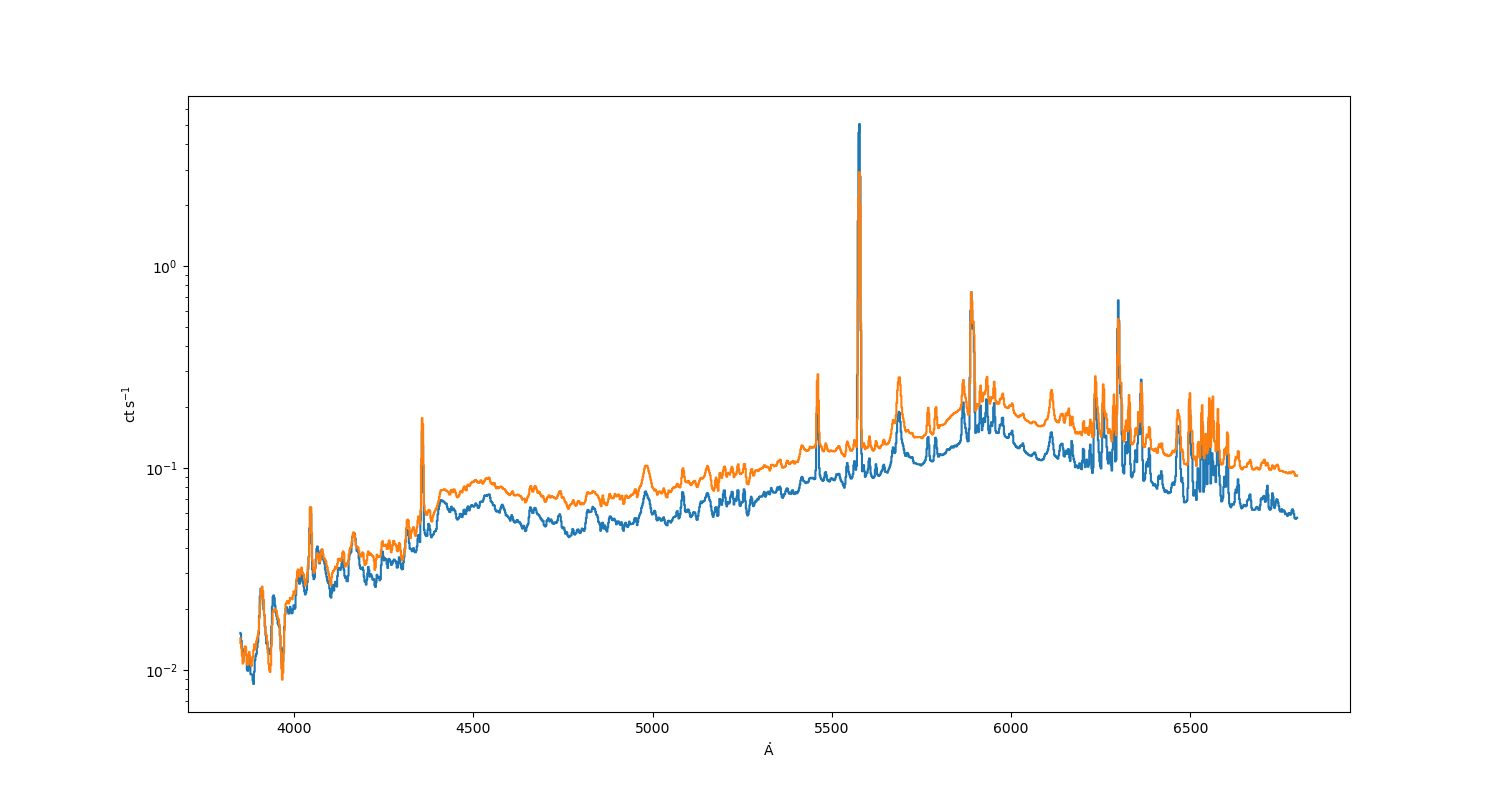

In [20]:
plt.figure(figsize=[15,8])
plt.step(new_test.spectral_axis, new_test.flux)
plt.step(new_t2.spectral_axis, new_t2.flux)
plt.yscale('log')
plt.show()